# Target echo and inspection angle distribution: AR=1.3

Note in this notebook we did not use `df_summary["TRIAL_TO_INCLUDE"]` to exclude unusable trials, because none of the unusable trials were included in the clustering analysis.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from pp_utils.core import generate_data_path_dict, MISC_PARAMS
from pp_utils.file_handling import df_main_loader
from pp_utils import utils
import pp_utils.inspection_angle as ia

In [3]:
import pickle

## Set paths, load main info df and clusters

In [4]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and output path

In [5]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [6]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

### Load main dataframe

In [7]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load clustering results

In [8]:
with open(output_path / "clustering_7_rostrum_only.pickle", "rb") as filein:
    cluster_fnameprefix_7 = pickle.load(filein)

### Load compiled trial info and track portion

In [9]:
df_summary = pd.read_csv(output_path / "data_summary_all.csv", index_col=0)

In [10]:
with open(output_path / "track_portion_all.pickle", "rb") as filein:
    df_track_portion_all = pickle.load(filein)

### Spheroid echo files

In [11]:
spheroid_echo_path = data_path["main"] / "spheroid_echoes/202307"

In [12]:
spheroid_echo_files = {
    "1.0": "ar1.0_TS.nc",
    "1.3": "ar1.3_TS.nc",
}

## Sort clusters

### 7clusters

In [13]:
# Clean up clusters
# 0: TC-straight, 1: TC-very curved, 2: TC-curved (need to change sequence to: 0-2-1)
# 3: CT-very curved, 4: CT-curved, 6: CT-straight (need to change sequence to: 6-4-3)
df_cluster_7 = []
for seq, fp_list in enumerate(cluster_fnameprefix_7):
    df_sel = utils.sort_df_in_cluster(fp_list, df_summary)
    df_cluster_7.append(df_sel)

In [14]:
# Change sequence
new_seq = [0, 2, 1, 6, 4, 3]
df_cluster_clean_7 = []
for seq in new_seq:
    df_cluster_clean_7.append(df_cluster_7[seq])

In [15]:
# Sanity check that we've swapped things correctly
print([len(df) for df in df_cluster_7])
print([len(df) for df in df_cluster_clean_7])

[16, 9, 16, 6, 8, 1, 23]
[16, 16, 9, 23, 8, 6]


## Get inspection angle distribution for all `TARGET_ANGLE` scenarios

### Function

In [16]:
def get_clicks(trial_idx, th_range=7):

    # Load TrialProcessor object
    tp_obj_fname = tp_path / f"trial_{trial_idx:03d}.pickle"
    with open(tp_obj_fname, "rb") as filein:
        tp = pickle.load(filein)

    # Time when animal reaching range threshold
    time_range_th = utils.get_time_range_threshold(
        df_tr=tp.df_track.dropna(subset=["DTAG_dist_elliptical"]).copy(),
        th_range=th_range
    )
    
    # Filter clicks
    # time_last_scan_start is only used for filter_clicks_close_before_last_scan
    # time_far_start is only used for filter_clicks_far
    df_ch0 = utils.filter_clicks_far(
        df_h=tp.df_hydro_ch0.copy(),
        th_RL=MISC_PARAMS["th_RL"],
        time_range_th=time_range_th,
        time_decision=tp.last_scan_end,
        time_far_start=df_track_portion_all[trial_idx]["time_corrected"].values[0]
    )
    df_ch1 = utils.filter_clicks_far(
        df_h=tp.df_hydro_ch1.copy(),
        th_RL=MISC_PARAMS["th_RL"],
        time_range_th=time_range_th,
        time_decision=tp.last_scan_end,
        time_far_start=df_track_portion_all[trial_idx]["time_corrected"].values[0]
    )

    # Print if decision made before reaching range threshold
    if tp.last_scan_end < time_range_th:
        print(f"Trial {trial_idx}: decision made before reaching range threshold!")

    # Check if any df is empty
    if isinstance(df_ch0, pd.DataFrame) and len(df_ch0) == 0:
        print(f"Trial {trial_idx}: df_ch0 is empty")
    if isinstance(df_ch1, pd.DataFrame) and len(df_ch1) == 0:
        print(f"Trial {trial_idx}: df_ch1 is empty")
    
    # Create a column for flipped angle
    df_ch0["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch0["enso_angle"])
    df_ch1["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1["enso_angle"])

    return df_ch0, df_ch1

### Set up clusters to plot for each  `TARGET_ANGLE` scenario

In [17]:
TARGET_ANGLE_STR = ["TC1", "TC2", "TC3", "TC4", "CT1", "CT2", "CT3", "CT4"]

In [18]:
TARGET_ANGLE_STR_NEW = [
    "R+/0", "R+/45", "R+/90", "R+/135",
    "L+/0", "L+/45", "L+/90", "L+/135",
]

Select trials in the dominant cluster under each `TARGET_ANGLE` scenario by referenceing the contingency matrix.

In [19]:
df_all = dict()

# TC1 in TC-Straight
dff = df_cluster_clean_7[0]
df_all["TC1"] = dff[dff["TARGET_ANGLE"]=="TC1"]

# TC2 in TC-Straight
dff = df_cluster_clean_7[0]
df_all["TC2"] = dff[dff["TARGET_ANGLE"]=="TC2"]

# TC3 in TC-Curved2
dff = df_cluster_clean_7[2]
df_all["TC3"] = dff[dff["TARGET_ANGLE"]=="TC3"]

# TC4 in TC-Curved1
dff = df_cluster_clean_7[1]
df_all["TC4"] = dff[dff["TARGET_ANGLE"]=="TC4"]

# CT1 in CT-Straight
dff = df_cluster_clean_7[3]
df_all["CT1"] = dff[dff["TARGET_ANGLE"]=="CT1"]

# CT2 in CT-Curved2
dff = df_cluster_clean_7[-1]
df_all["CT2"] = dff[dff["TARGET_ANGLE"]=="CT2"]

# CT3 in CT-Straight
dff = df_cluster_clean_7[3]
df_all["CT3"] = dff[dff["TARGET_ANGLE"]=="CT3"]

# CT4 in CT-Straight
dff = df_cluster_clean_7[3]
df_all["CT4"] = dff[dff["TARGET_ANGLE"]=="CT4"]

Double check the TCA order in the dict:

In [20]:
assert list(df_all.keys()) == TARGET_ANGLE_STR

### Range threshold

In [21]:
# Range threshold
th_range = 7  # [m]

In [22]:
# Click RL threshold
MISC_PARAMS["th_RL"]

140

### Visualize angle "flip"

Convert the ensonification (0-360 deg) to the target measurement angle definition (-90 to 90 deg) by:
- flipping the angles around 180 deg
- shifting the flipped angles by 90 deg

In [23]:
enso_bin_test = np.arange(0, 365, 3.75)
x_hist_test = (enso_bin_test[:-1] + enso_bin_test[1:])/2
x_hist_sph_angle_test = ia.enso2spheroid_angle(x_hist_test)

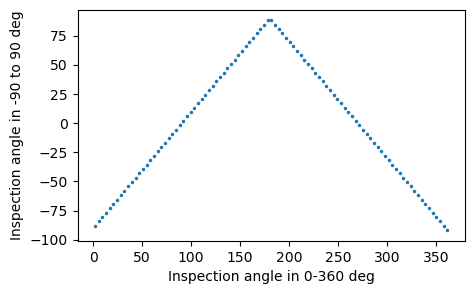

In [24]:
plt.figure(figsize=(5, 3))
plt.plot(x_hist_test, x_hist_sph_angle_test, ".", markersize=3)
plt.xlabel("Inspection angle in 0-360 deg")
plt.ylabel("Inspection angle in -90 to 90 deg")
plt.show()

### Set up binning params

In [25]:
enso_bin_size = 3.75
enso_bin_noflip = np.arange(0, 365, enso_bin_size)
enso_bin_flip = np.arange(-90, 95, enso_bin_size)
x_hist_noflip = (enso_bin_noflip[:-1] + enso_bin_noflip[1:])/2
x_hist_flip = (enso_bin_flip[:-1] + enso_bin_flip[1:])/2

### Get inspection angle distribution

In [26]:
# Gather all distribution mtx
ch0_mtx_all_noflip = dict()
ch1_mtx_all_noflip = dict()
ch0_mtx_all_flip = dict()
ch1_mtx_all_flip = dict()

for tca, dff in df_all.items():
    
    # Loop through all trial_idx in this cluster & TARGET_ANGLE combination
    trial_idx_all = dff.index
    
    ch0_dist_all_flip, ch1_dist_all_flip = [], []
    ch0_dist_all_noflip, ch1_dist_all_noflip = [], []
    for trial_idx in trial_idx_all:
        # Filter out clicks
        df_ch0, df_ch1 = get_clicks(trial_idx=trial_idx, th_range=th_range)

        # Get angle distribution for no-flip case
        binning_params = {
            "angle_bin": enso_bin_noflip,
            "time_binning": False,
            "density": False,
        }
        ch0_dist_noflip = ia.get_angle_dist(df_click=df_ch0, col_name="enso_angle", **binning_params)
        ch1_dist_noflip = ia.get_angle_dist(df_click=df_ch1, col_name="enso_angle", **binning_params)
        ch0_dist_all_noflip.append(ch0_dist_noflip)
        ch1_dist_all_noflip.append(ch1_dist_noflip)

        # Get angle distribution for flip case
        binning_params = {
            "angle_bin": enso_bin_flip,
            "time_binning": False,
            "density": False,
        }
        ch0_dist_flip = ia.get_angle_dist(df_click=df_ch0, col_name="enso_angle_flip", **binning_params)
        ch1_dist_flip = ia.get_angle_dist(df_click=df_ch1, col_name="enso_angle_flip", **binning_params)
        ch0_dist_all_flip.append(ch0_dist_flip)
        ch1_dist_all_flip.append(ch1_dist_flip)
    
    # Save for each cluster & TARGET_ANGLE combination
    ch0_mtx_all_noflip[tca] = np.array(ch0_dist_all_noflip)
    ch1_mtx_all_noflip[tca] = np.array(ch1_dist_all_noflip)
    ch0_mtx_all_flip[tca] = np.array(ch0_dist_all_flip)
    ch1_mtx_all_flip[tca] = np.array(ch1_dist_all_flip)

Trial 97: decision made before reaching range threshold!


## Decide how to normalized across trials

Let' check the number of clicks included in each TCA scenario:

In [27]:
# Ch0 - sphere
for tca, ch0_mtx in ch0_mtx_all_noflip.items():
    print(tca)
    print(ch0_mtx.sum(axis=1))

TC1
[ 7 11 20 10  9 15 20]
TC2
[ 7 18 21 20 16]
TC3
[23 16 11 12 14]
TC4
[11 14 12 15 16  6 17]
CT1
[20 25 23 14]
CT2
[25 28 27 13]
CT3
[23 18 16 16 19 24 22 24]
CT4
[29 14 21 25 19 15 17 19 19]


In [28]:
# Ch1 - spheroid
for tca, ch1_mtx in ch1_mtx_all_noflip.items():
    print(tca)
    print(ch1_mtx.sum(axis=1))

TC1
[11  8 25 10 15 18 28]
TC2
[13 26 23 27 26]
TC3
[30 27 22 21 20]
TC4
[17 21 16 23 25  8 15]
CT1
[13 21 18 10]
CT2
[25 20 21 15]
CT3
[17 18 13 11  9 16 17 13]
CT4
[14 11 16 16 14 10 16 18 13]


There is a pretty large variation on the number of clicks included in each trial. So a better way to normalize the data across trials is likely averaging the ~number~ relative frequency across all trials, not summing up the number of clicks and then do a overall histogram.

### Averaging ~number~ relative frequency histogram across trials

In [29]:
ch0_mtx_norm_noflip = dict()
ch1_mtx_norm_noflip = dict()
ch0_mtx_norm_flip = dict()
ch1_mtx_norm_flip = dict()

# Compute the relative frequency histogram

# NO FLIP CASE
# Ch0 - sphere
for tca, mtx in ch0_mtx_all_noflip.items():
    tmp = (mtx.T / mtx.sum(axis=1)).T
    ch0_mtx_norm_noflip[tca] = tmp.mean(axis=0)

# Ch1 - spheroid
for tca, mtx in ch1_mtx_all_noflip.items():
    tmp = (mtx.T / mtx.sum(axis=1)).T
    ch1_mtx_norm_noflip[tca] = tmp.mean(axis=0)

# FLIP CASE
# Ch0 - sphere
for tca, mtx in ch0_mtx_all_flip.items():
    tmp = (mtx.T / mtx.sum(axis=1)).T
    ch0_mtx_norm_flip[tca] = tmp.mean(axis=0)

# Ch1 - spheroid
for tca, mtx in ch1_mtx_all_flip.items():
    tmp = (mtx.T / mtx.sum(axis=1)).T
    ch1_mtx_norm_flip[tca] = tmp.mean(axis=0)

### Plot inspection angle histogram

In [30]:
plot_params_ch0 = {
    "alpha": 0.5,
    "edgecolor": "k",
    "facecolor": "C0",
    "linewidth": 1
}
plot_params_ch1 = plot_params_ch0.copy()
plot_params_ch1["facecolor"] = "C1"

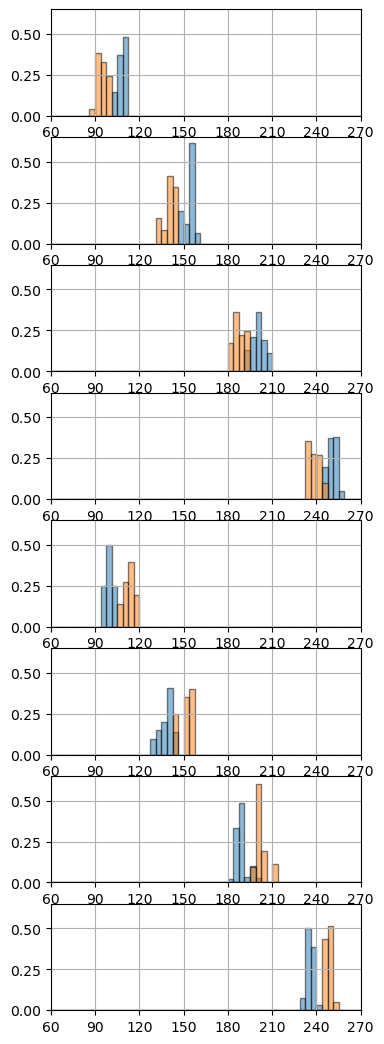

In [31]:
fig,ax = plt.subplots(8, 1, figsize=(4, 13))


# Angle flipped AFTER binning
for tca_seq, tca in enumerate(TARGET_ANGLE_STR):
    
    # Size check
    assert ch0_mtx_norm_noflip[tca].size == ch1_mtx_norm_noflip[tca].size

    # plot histograms
    axx = ax[tca_seq]
    axx.bar(x=x_hist_noflip, width=enso_bin_size, height=ch0_mtx_norm_noflip[tca], **plot_params_ch0)
    axx.bar(x=x_hist_noflip, width=enso_bin_size, height=ch1_mtx_norm_noflip[tca], **plot_params_ch1)
    axx.set_xlim(60, 270)
    axx.set_xticks(np.arange(60, 290, 30))
    axx.set_ylim(0, 0.65)
    axx.grid()

plt.show()

## Get sphere/spheroid echo measurements: freq domain (TS)

In [32]:
ch0_echo = ia.get_spheroid_echo(
    sph_echo_angle=np.arange(0, 105, 15), sph_ar="1.0",
    sph_path=spheroid_echo_path, sph_file=spheroid_echo_files
)
ch1_echo = ia.get_spheroid_echo(
    sph_echo_angle=np.arange(0, 105, 15), sph_ar="1.3",
    sph_path=spheroid_echo_path, sph_file=spheroid_echo_files
)

In [33]:
# Get the max and min vertical (angle) extent for imshow
angle_delta = ch0_echo["angle"].data[1] - ch0_echo["angle"].data[0]
angle = -angle_delta/2, angle_delta*(ch0_echo.shape[0]-1) + angle_delta/2
angle

(-7.5, 97.5)

In [34]:
# Get the max and min horizontal (frequency) extent for imshow
freq = ch0_echo["frequency"].values[[0, -1]]
freq

array([     0.     , 249511.71875])

### TS imshow comparison

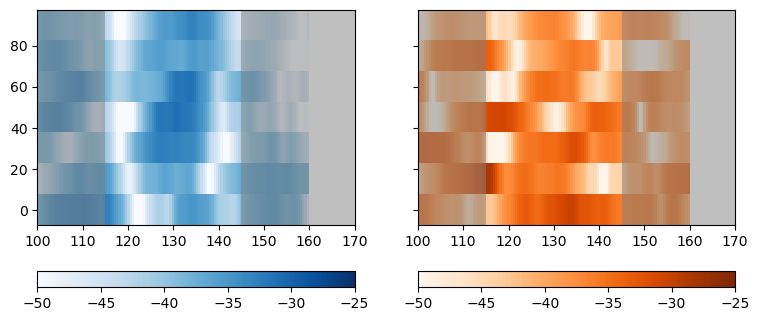

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
im0 = ax[0].imshow(
    ch0_echo, aspect="auto", interpolation="none",
    extent=(freq[0], freq[1]/1e3, angle[1], angle[0]),  # note inverted Y
    vmin=-50, vmax=-25, cmap="Blues"
)
im1 = ax[1].imshow(
    ch1_echo, aspect="auto", interpolation="none",
    extent=(freq[0], freq[1]/1e3, angle[1], angle[0]),  # note inverted Y
    vmin=-50, vmax=-25, cmap="Oranges"
)
for axx in ax:
    axx.set_xlim(100, 170)
    axx.set_ylim(angle[0], angle[1])
    axx.fill_betweenx(y=np.arange(-10, 100), x1=0, x2=115, facecolor="grey", alpha=0.5)
    axx.fill_betweenx(y=np.arange(-10, 100), x1=145, x2=200, facecolor="grey", alpha=0.5)
plt.colorbar(im0, ax=ax[0], orientation="horizontal")
plt.colorbar(im1, ax=ax[1], orientation="horizontal")
plt.show()

## Plot TS curves that are at prominent angles

Plot the echo spectrum for:
- the most dominant angle (solid line)
- the second most dominant angle, if it is above the peak threshold (dashed line)

In [36]:
# Peak threshold
peak_threshold = 0.75

In [37]:
# Sanity check of dimensions
assert x_hist_flip.shape == ch0_mtx_norm_flip["TC1"].shape

In [38]:
x_hist_flip

array([-88.125, -84.375, -80.625, -76.875, -73.125, -69.375, -65.625,
       -61.875, -58.125, -54.375, -50.625, -46.875, -43.125, -39.375,
       -35.625, -31.875, -28.125, -24.375, -20.625, -16.875, -13.125,
        -9.375,  -5.625,  -1.875,   1.875,   5.625,   9.375,  13.125,
        16.875,  20.625,  24.375,  28.125,  31.875,  35.625,  39.375,
        43.125,  46.875,  50.625,  54.375,  58.125,  61.875,  65.625,
        69.375,  73.125,  76.875,  80.625,  84.375,  88.125,  91.875])

In [39]:
echo_angle_edges = np.arange(angle[0], angle[1]+angle_delta, angle_delta)
echo_angle_edges

array([-7.5,  7.5, 22.5, 37.5, 52.5, 67.5, 82.5, 97.5])

### Check detail of using `np.digitize` to find the 1st and 2nd most dominant angles

In [40]:
tca = "TC1"

<BarContainer object of 49 artists>

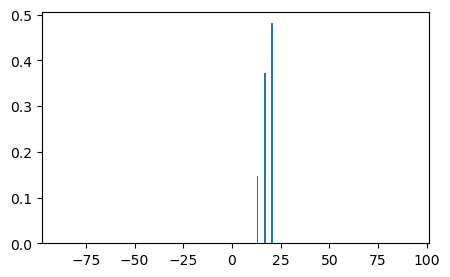

In [41]:
plt.figure(figsize=(5, 3))
plt.bar(x_hist_flip, ch0_mtx_norm_flip[tca])

In [42]:
# Select bars above threshold
norm_bar_peak = ch0_mtx_norm_flip[tca].max()
p_idx = np.argwhere(ch0_mtx_norm_flip[tca] > norm_bar_peak * peak_threshold).squeeze()

# Sort the indices based on relative frequency
p_idx = p_idx[np.argsort(ch0_mtx_norm_flip[tca][p_idx])[::-1]]

p_idx

array([29, 28])

In [43]:
x_hist_flip[p_idx]

array([20.625, 16.875])

In [44]:
coarse_angle_idx = np.digitize(x_hist_flip[p_idx], echo_angle_edges)
coarse_angle_idx

array([2, 2])

In [45]:
echo_angle_edges.size

8

In [46]:
ch0_echo["angle"].values

array([ 0, 15, 30, 45, 60, 75, 90], dtype=int32)

In [47]:
ch0_echo["angle"].values[coarse_angle_idx-1]

array([15, 15], dtype=int32)

In [48]:
# Using plain unique will change the sequence
# Also need to record the sequence index going into the unique
_, unique_idx = np.unique(ch0_echo["angle"].values[coarse_angle_idx-1], return_index=True)
unique_idx

array([0])

In [49]:
# The angle will be based on the sequence index
ch0_echo["angle"].values[coarse_angle_idx-1][np.sort(unique_idx)]

array([15], dtype=int32)

### Turn the procedure into function

In [50]:
def get_prominant_angles(
    tca_norm, possible_angles,
    x_hist=x_hist_flip,
    echo_angle_edges_tmp=echo_angle_edges
):
    """
    Get the most prominent ensonification angles.
    """
    
    # Select bars above threshold
    norm_bar_peak = tca_norm.max()
    p_idx = np.argwhere(tca_norm > norm_bar_peak * peak_threshold).squeeze()

    if p_idx.size > 1:
        # Sort the indices based on relative frequency
        p_idx = p_idx[np.argsort(tca_norm[p_idx])[::-1]]

        # Get a sorted list of corresponding angles
        coarse_angle_idx = np.digitize(x_hist[p_idx], echo_angle_edges_tmp)
        _, unique_idx = np.unique(possible_angles[coarse_angle_idx-1], return_index=True)

        return possible_angles[coarse_angle_idx-1][np.sort(unique_idx)]
    else:
        p_hist, _ = np.histogram(x_hist[p_idx], bins=echo_angle_edges_tmp)
        return possible_angles[p_hist!=0]

In [51]:
# Test the function: CT1
p_angles_ch0 = get_prominant_angles(
    ch0_mtx_norm_flip["CT1"], possible_angles=ch0_echo["angle"].values
)
p_angles_ch1 = get_prominant_angles(
    ch1_mtx_norm_flip["CT1"], possible_angles=ch0_echo["angle"].values
)
(p_angles_ch0, p_angles_ch1)

(array([15], dtype=int32), array([30], dtype=int32))

In [52]:
# Test the function: CT3
p_angles_ch0 = get_prominant_angles(
    ch0_mtx_norm_flip["CT3"], possible_angles=ch0_echo["angle"].values
)
p_angles_ch1 = get_prominant_angles(
    ch1_mtx_norm_flip["CT3"], possible_angles=ch0_echo["angle"].values
)
(p_angles_ch0, p_angles_ch1)

(array([75], dtype=int32), array([75], dtype=int32))

### Function to plot echo spectrum contour

In [53]:
def contour_cmp(axx, ch0_angles, ch1_angles, vert_spacing=0, alpha=0.5, dashes=[(1,0), (1,0.8)]):
    # TS
    for a_seq, aa in enumerate(ch0_angles):
        axx.plot(
            ch0_echo["frequency"]/1e3, ch0_echo.sel(angle=aa) + a_seq*vert_spacing,
            "C0", dashes=dashes[a_seq]
        )
    for a_seq, aa in enumerate(ch1_angles):
        axx.plot(
            ch0_echo["frequency"]/1e3, ch1_echo.sel(angle=aa) + a_seq*vert_spacing,
            "C1", dashes=dashes[a_seq]
        )

    # Vertical stripe for porpoise frequency band
    axx.fill_betweenx(y=np.arange(-60, 10), x1=0, x2=115, facecolor="darkgrey", alpha=alpha)
    axx.fill_betweenx(y=np.arange(-60, 10), x1=145, x2=200, facecolor="darkgrey", alpha=alpha)
            
    axx.set_xlim(100, 160)
    axx.set_ylim(-60, -25)

### Plotting to check

TC1
  ch0: [15]
  ch1:[0]
TC2
  ch0: [60]
  ch1:[45 60]
TC3
  ch0: [75]
  ch1:[90]
TC4
  ch0: [15]
  ch1:[30]
CT1
  ch0: [15]
  ch1:[30]
CT2
  ch0: [45]
  ch1:[60]
CT3
  ch0: [75]
  ch1:[75]
CT4
  ch0: [30]
  ch1:[15 30]


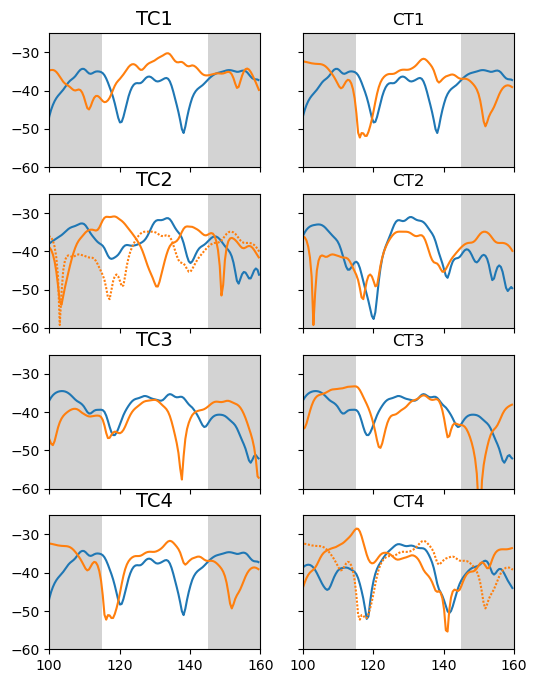

In [54]:
fig,ax = plt.subplots(4, 2, figsize=(6,8), sharex=True, sharey=True)

# TC scenarios
for tca_seq, tca in enumerate(TARGET_ANGLE_STR[:4]):
    # Get prominant angles for this TCA scenario
    p_angles_ch0 = get_prominant_angles(
        ch0_mtx_norm_flip[tca], possible_angles=ch0_echo["angle"].values)
    p_angles_ch1 = get_prominant_angles(
        ch1_mtx_norm_flip[tca], possible_angles=ch1_echo["angle"].values)    
    print(tca)
    print(f"  ch0: {p_angles_ch0}\n  ch1:{p_angles_ch1}")
    
    # Plot axis
    contour_cmp(axx=ax[tca_seq, 0], ch0_angles=p_angles_ch0, ch1_angles=p_angles_ch1)
    ax[tca_seq, 0].set_title(tca, fontsize=14)

# CT scenarios
for tca_seq, tca in enumerate(TARGET_ANGLE_STR[4:]):
    # Get prominant angles for this TCA scenario
    p_angles_ch0 = get_prominant_angles(
        ch0_mtx_norm_flip[tca], possible_angles=ch0_echo["angle"].values)
    p_angles_ch1 = get_prominant_angles(
        ch1_mtx_norm_flip[tca], possible_angles=ch1_echo["angle"].values)    
    print(tca)
    print(f"  ch0: {p_angles_ch0}\n  ch1:{p_angles_ch1}")

    # Plot axis
    contour_cmp(axx=ax[tca_seq, 1], ch0_angles=p_angles_ch0, ch1_angles=p_angles_ch1)
    ax[tca_seq, 1].set_title(tca, fontsize=12)

## Put angle distribution and TS spectrum together

### Functions for line legend

In [55]:
p_angles_ch0

array([30], dtype=int32)

In [56]:
p_angles_ch1

array([15, 30], dtype=int32)

In [57]:
def plot_line_legends(
    ax, a_ch0, a_ch1,  # angles for each channel
    line_len=10, line_height=[0.64, 0.61], dash_style=[(1,0), (1,0.9)]
):
    shift_C1 = False
    
    # If the first angle is the same for both colors, need to shift C1 down
    if a_ch1[0] == a_ch0[0]:
        shift_C1 = True
    # Plot lines in sequence: first angle for both targets, second angle for both colors
    for a_seq in range(2):
        for a_target, a_color in zip([a_ch0, a_ch1], ["C0", "C1"]):
            if len(a_target) > a_seq:
                vert_shift = 0
                if shift_C1:
                    # Shift C1 down if first angle identical for C0 and C1
                    if a_seq==0 and a_color=="C1":
                        vert_shift = -0.03
                    if a_seq==1 and a_color == "C0":
                        vert_shift = +0.03
                ax.plot(
                    np.array([a_target[a_seq]-line_len/2, a_target[a_seq]+line_len/2]),
                    np.ones(2)*line_height[a_seq] + vert_shift,
                    dashes=dash_style[a_seq], lw=1.5, color=a_color
                )

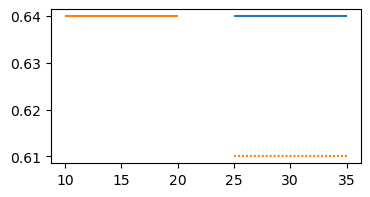

In [58]:
fig, ax = plt.subplots(1,1,figsize=(4,2))
plot_line_legends(ax=ax, a_ch0=p_angles_ch0, a_ch1=p_angles_ch1)

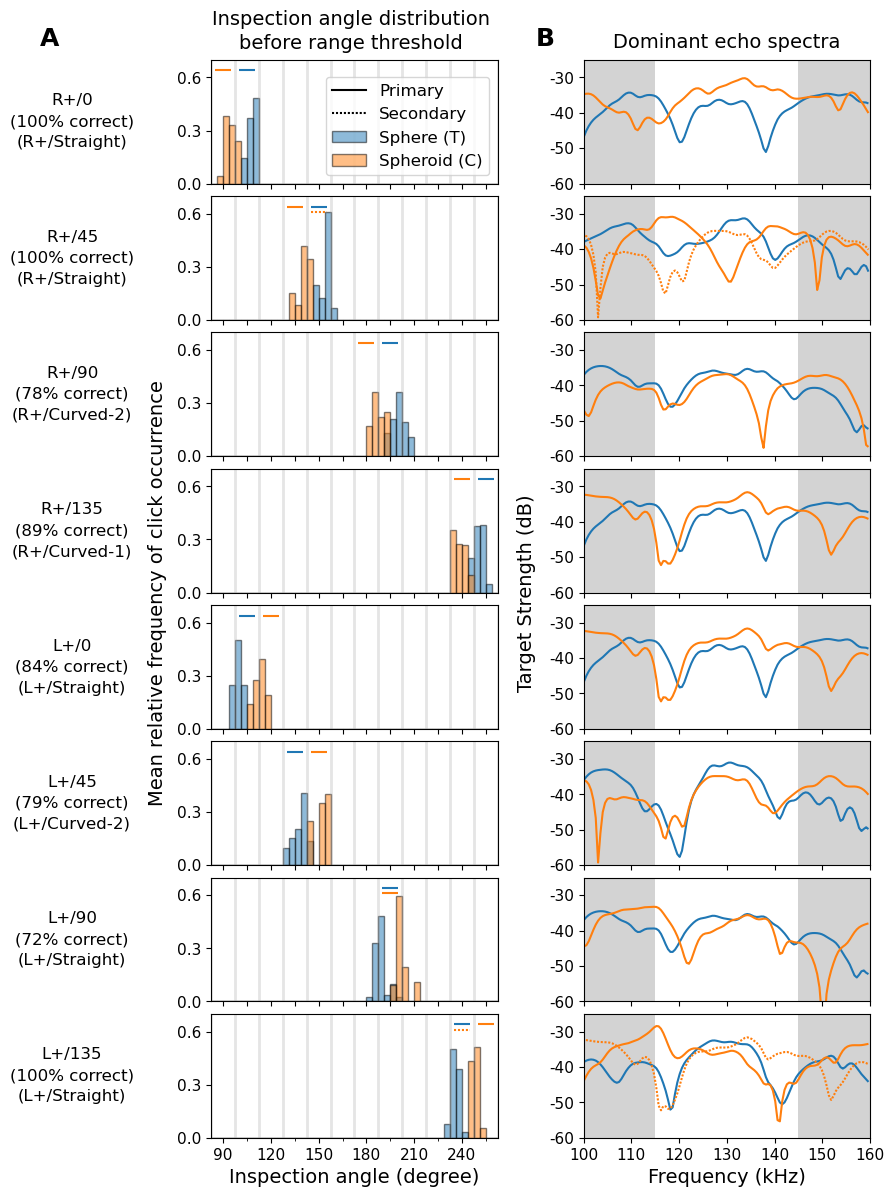

In [59]:
fig, ax = plt.subplots(8, 2, figsize=(8.5, 14), facecolor="w")#, constrained_layout=True)

plt.subplots_adjust(wspace=0.3, hspace=0.1)

# ==========================
# Sphere inspection angles
# ==========================
for tca_seq, tca in enumerate(TARGET_ANGLE_STR):
    
    # Size check
    assert ch0_mtx_norm_noflip[tca].size == ch1_mtx_norm_noflip[tca].size

    # plot histograms
    axx = ax[tca_seq, 0]
    axx.bar(x=x_hist_noflip, width=enso_bin_size, height=ch0_mtx_norm_noflip[tca], **plot_params_ch0)
    axx.bar(x=x_hist_noflip, width=enso_bin_size, height=ch1_mtx_norm_noflip[tca], **plot_params_ch1)

#     axx.set_title(tca, fontsize=14)
    axx.set_ylim(0, 0.7)
    axx.set_yticks(np.arange(0, 0.7, 0.3))
    axx.set_yticklabels(np.arange(0, 0.7, 0.3), fontsize=11)

    if tca_seq != len(TARGET_ANGLE_STR)-1:
        axx.set_xticklabels("")
        axx.set_xticks(np.arange(60, 290, 15), minor=False)
    else:
        axx.set_xticks(np.arange(60, 290, 30), minor=False)
        axx.set_xticks(np.arange(60, 290, 15), minor=True)
        axx.set_xticklabels(np.arange(60, 290, 30), minor=False, fontsize=11)
        # axx.set_xticklabels(np.arange(60, 290, 30), fontsize=11)
        
    # vertical line for angle boundaries
    for h in np.arange(90-7.5, 290, 15):
        axx.axvline(h, color="darkgrey", lw=2, alpha=0.3)

    axx.set_xlim(90-7.5, 255+7.5)

ax[-1, 0].set_xlabel("Inspection angle (degree)", fontsize=14)
ax[3, 0].text(43, 0, "Mean relative frequency of click occurrence",
              fontsize=14, va="center", rotation=90)
    
# ==========================
# TS curves
# ==========================
for tca_seq, tca in enumerate(TARGET_ANGLE_STR):
    # Get prominant angles for this TCA scenario
    p_angles_ch0 = get_prominant_angles(
        ch0_mtx_norm_flip[tca], possible_angles=ch0_echo["angle"].values)
    p_angles_ch1 = get_prominant_angles(
        ch1_mtx_norm_flip[tca], possible_angles=ch1_echo["angle"].values)    

    # Plot axis
    axx = ax[tca_seq, 1]
    contour_cmp(axx=axx, ch0_angles=p_angles_ch0, ch1_angles=p_angles_ch1, alpha=0.5)
    
    axx.set_ylim(-60, -25)
    axx.set_yticks(np.arange(-60, -25, 10))
    axx.set_yticklabels(np.arange(-60, -25, 10), fontsize=11)
    axx.set_xlim(100, 160)
    axx.set_xticks(np.arange(100, 170, 10))
    if tca_seq != len(TARGET_ANGLE_STR)-1:
        axx.set_xticklabels("")
    else:
        axx.set_xticklabels(np.arange(100, 170, 10), fontsize=11)
        
    # Plot on Panel A: legends for primary and secondary spectra
    p_angles_ch0_noflip = get_prominant_angles(
        ch0_mtx_norm_noflip[tca], possible_angles=np.arange(0,390, 15),
        x_hist=x_hist_noflip, echo_angle_edges_tmp=np.arange(0,405, 15)-7.5
    )
    p_angles_ch1_noflip = get_prominant_angles(
        ch1_mtx_norm_noflip[tca], possible_angles=np.arange(0,390, 15),
        x_hist=x_hist_noflip, echo_angle_edges_tmp=np.arange(0,405, 15)-7.5
    )    
    axx_A = ax[tca_seq, 0]
    plot_line_legends(ax=axx_A, a_ch0=p_angles_ch0_noflip, a_ch1=p_angles_ch1_noflip)


ax[-1, 1].set_xlabel("Frequency (kHz)", fontsize=14)
ax[3, 1].text(86, -60, "Target Strength (dB)", fontsize=14, va="center", rotation=90)


# Add condition labels to the left of all panels
perc_correct_list = []
for tca in TARGET_ANGLE_STR:
    val_choice = df_main.loc[
        (df_main["TARGET_ANGLE"]==tca) & (df_main["SPHEROID"]=="M")
    ]["CHOICE"]
    perc_correct_list.append(val_choice[val_choice==1].size / val_choice.size *100)
condition_list = [
    "R+/0", "R+/45", "R+/90", "R+/135",
    "L+/0", "L+/45", "L+/90", "L+/135"
]
cluster_list = [
    "R+/Straight", "R+/Straight", "R+/Curved-2", "R+/Curved-1",
    "L+/Straight", "L+/Curved-2", "L+/Straight", "L+/Straight"
]

x_pos = -5
y_pos = 0.35
for axi, cl1, cl2, cl3 in zip(
    range(8), condition_list, perc_correct_list, cluster_list
):
    ax_label = f"{cl1}\n({cl2:2.0f}% correct)\n({cl3})"
    ax[axi, 0].text(
        x_pos, y_pos, ax_label, linespacing=1.5,
        ha="center", va="center", fontsize=12
    )

# Panel labels
ax[0, 0].text(-25, 0.75, "A", va="bottom", fontsize=18, fontweight="bold")
ax[0, 1].text(90, -22.5, "B", va="bottom", fontsize=18, fontweight="bold")


# Panel titles
ax[0, 0].text(
    170, 0.86, "Inspection angle distribution\nbefore range threshold",
    ha="center", va="center", fontsize=14, linespacing=1.35
)
ax[0, 1].text(
    130, -20, "Dominant echo spectra", ha="center", va="center", fontsize=14
)

# Line legend
ax[0, 0].plot(np.nan, np.nan, ls="-", color="k", label="Primary")
ax[0, 0].plot(np.nan, np.nan, dashes=[1, 0.9], color="k", label="Secondary")
ax[0, 0].bar(x=np.nan, width=enso_bin_size, height=np.nan, **plot_params_ch0, label="Sphere (T)")
ax[0, 0].bar(x=np.nan, width=enso_bin_size, height=np.nan, **plot_params_ch1, label="Spheroid (C)")
ax[0, 0].legend(fontsize=12, loc="lower right")


    
plt.show()

fig.savefig(fig_path / "fig_echo_angle_TS_0.75_noflip.png", dpi=300, bbox_inches="tight")
